In [65]:
import numpy as np
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [66]:
path = kagglehub.dataset_download("philiphyde1/nfl-stats-1999-2022")

# Load offense dataset
wk_offense_df = pd.read_csv(path + "\weekly_player_stats_offense.csv")
yr_offense_df = pd.read_csv(path + "\yearly_player_stats_offense.csv")

In [95]:

for col in yr_offense_df.columns:
    print(col)


player_id
player_name
position
birth_year
draft_year
draft_round
draft_pick
draft_ovr
height
weight
college
season
season_type
team
conference
division
shotgun
no_huddle
qb_dropback
qb_scramble
pass_attempts
complete_pass
incomplete_pass
passing_yards
receiving_yards
yards_after_catch
rush_attempts
rushing_yards
tackled_for_loss
first_down_pass
first_down_rush
third_down_converted
third_down_failed
fourth_down_converted
fourth_down_failed
rush_touchdown
pass_touchdown
safety
interception
fumble
fumble_lost
fumble_forced
fumble_not_forced
fumble_out_of_bounds
receptions
targets
passing_air_yards
receiving_air_yards
receiving_touchdown
pass_attempts_redzone
complete_pass_redzone
pass_touchdown_redzone
pass_attempts_gtg
complete_pass_gtg
pass_touchdown_gtg
receptions_redzone
targets_redzone
receiving_touchdown_redzone
receptions_gtg
targets_gtg
receiving_touchdown_gtg
rush_attempts_redzone
rush_touchdown_redzone
rush_attempts_gtg
rush_touchdown_gtg
fantasy_points_ppr
fantasy_points_standa

In [93]:
offense_data_mask = (
    (wk_offense_df["season"] == 2024) &
    (wk_offense_df["position"].isin(["RB", "WR", "QB", "TE"]))
)
offense_data_mask_2 = (
    (yr_offense_df["season"] == 2024) &
    (yr_offense_df["position"].isin(["RB", "WR", "QB", "TE"]))
)



offense_2024 = wk_offense_df[offense_data_mask][["player_name","position","team", "season","week", "rushing_yards", "rush_touchdown", "passing_yards", 
                                                "pass_touchdown", "interception", "receiving_yards", "receiving_touchdown", "receptions",
                                                ]]
#store all offensive player stats




In [78]:
from sklearn.preprocessing import StandardScaler

# Select the numeric stat columns
stat_cols = [
    "rushing_yards", "rush_touchdown",
    "passing_yards", "pass_touchdown", "interception",
    "receiving_yards", "receiving_touchdown", "receptions"
]

# Initialize scaler
scaler = StandardScaler()

# Fit + transform stats columns
offense_2024_scaled = offense_2024.copy()
offense_2024_scaled[stat_cols] = scaler.fit_transform(offense_2024[stat_cols])

# Now offense_2024_scaled has standardized values (mean=0, std=1)
print(offense_2024_scaled.head())

         player_name position team  season  week  rushing_yards  \
53682  Aaron Rodgers       QB  NYJ    2024     1      -0.520322   
53683  Aaron Rodgers       QB  NYJ    2024     2      -0.446428   
53684  Aaron Rodgers       QB  NYJ    2024     3       0.181669   
53685  Aaron Rodgers       QB  NYJ    2024     4       0.477245   
53686  Aaron Rodgers       QB  NYJ    2024     5      -0.483375   

       rush_touchdown  passing_yards  pass_touchdown  interception  \
53682       -0.286033       1.835370        0.967603      1.892190   
53683       -0.286033       1.952980        2.402945     -0.341200   
53684       -0.286033       3.325096        2.402945     -0.341200   
53685       -0.286033       2.593301       -0.467739     -0.341200   
53686       -0.286033       2.841589        2.402945      6.358969   

       receiving_yards  receiving_touchdown  receptions  
53682          -0.8051            -0.382157   -0.961467  
53683          -0.8051            -0.382157   -0.961467  
53

In [77]:
import pandas as pd

# Aggregate stats by player across the season
player_stats = offense_2024_scaled.groupby("player_name")[stat_cols].sum().reset_index()

from sklearn.decomposition import PCA
# Initialize PCA
pca = PCA(n_components=4)  # pick 2D for visualization, could try more

# Fit PCA on player stats
principal_components = pca.fit_transform(player_stats[stat_cols])

# Add PCA components back to dataframe
player_stats_pca = player_stats.copy()
player_stats_pca["PC1"] = principal_components[:, 0]
player_stats_pca["PC2"] = principal_components[:, 1]
player_stats_pca["PC3"] = principal_components[:, 2]
player_stats_pca["PC4"] = principal_components[:, 3]
pc_means = player_stats_pca[["PC1", "PC2"]].mean()

player_positions = offense_2024[["player_name", "position"]].drop_duplicates(subset=["player_name"])


player_stats_pca = player_stats_pca.merge(player_positions, on="player_name", how="left")
print(player_stats_pca)



       player_name  rushing_yards  rush_touchdown  passing_yards  \
0      A.J. Barner      -6.767245       -4.004460      -4.857272   
1       A.J. Brown      -7.733994       -4.576526      -5.551168   
2      Aaron Jones      33.828198        8.505772      -5.898116   
3    Aaron Rodgers      -4.264051       -4.862559      45.026994   
4     Adam Thielen      -1.450124       -0.858099      -1.040844   
..             ...            ...             ...            ...   
458      Zach Ertz      -9.184118       -5.434625      -6.592012   
459      Zack Moss       5.074152        3.059070      -2.775584   
460    Zamir White       2.894285        0.385403      -2.775584   
461    Zay Flowers      -6.148343       -4.862559      -5.898116   
462      Zay Jones      -2.416873       -1.430164      -1.734740   

     pass_touchdown  interception  receiving_yards  receiving_touchdown  \
0         -0.806975     -2.543404        -3.357827             4.381067   
1          5.434258      1.240976

KeyError: 'fantasy_points_ppr'

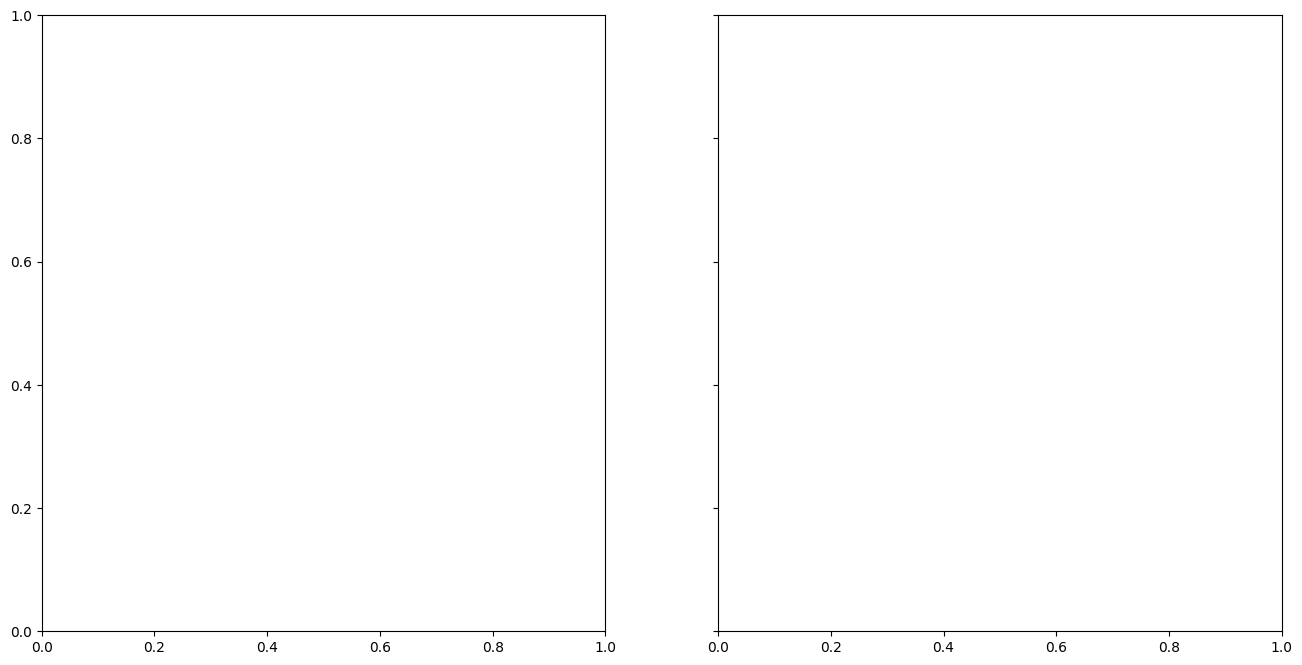

In [96]:
import matplotlib.pyplot as plt

# Merge yearly fantasy points into PCA DataFrame
player_stats_pca = player_stats_pca.merge(
    yr_offense_df[["player_name", "fantasy_points_ppr", "fantasy_points_standard"]],
    on="player_name",
    how="left"
)

# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(16,8), sharey=True)

# Plot 1: Distance vs PPR points (yearly)
axes[0].scatter(
    player_stats_pca["distance_from_mean"], 
    player_stats_pca["fantasy_points_ppr"], 
    alpha=0.7, color="blue"
)
for i, row in player_stats_pca.iterrows():
    axes[0].text(
        row["distance_from_mean"], 
        row["fantasy_points_ppr"], 
        row["player_name"], 
        fontsize=7, alpha=0.8
    )
axes[0].set_xlabel("Distance from PCA Mean (PC1, PC2)")
axes[0].set_ylabel("Fantasy Points (PPR, Yearly)")
axes[0].set_title("Distance vs Fantasy Points (PPR, Yearly)")

# Plot 2: Distance vs Standard points (yearly)
axes[1].scatter(
    player_stats_pca["distance_from_mean"], 
    player_stats_pca["fantasy_points_standard"], 
    alpha=0.7, color="green"
)
for i, row in player_stats_pca.iterrows():
    axes[1].text(
        row["distance_from_mean"], 
        row["fantasy_points_standard"], 
        row["player_name"], 
        fontsize=7, alpha=0.8
    )
axes[1].set_xlabel("Distance from PCA Mean (PC1, PC2)")
axes[1].set_ylabel("Fantasy Points (Standard, Yearly)")
axes[1].set_title("Distance vs Fantasy Points (Standard, Yearly)")

plt.tight_layout()
plt.show()



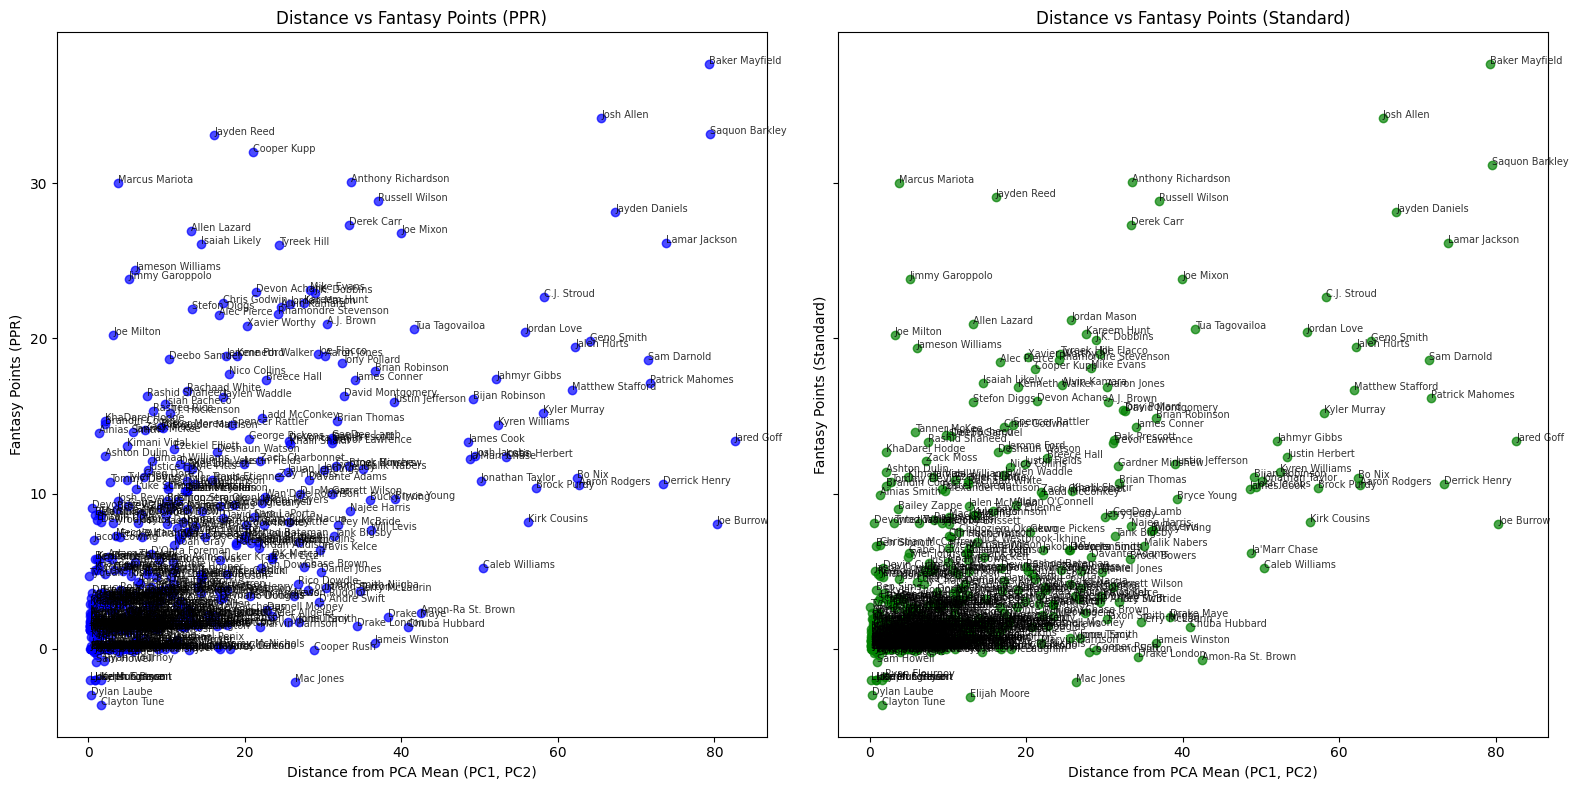

In [94]:
offense_2024_ppr = yr_offense_df[offense_data_mask_2][["player_name","position","fantasy_points_ppr",
                                                ]]

offense_2024_standard = yr_offense_df[offense_data_mask_2][["player_name","position","fantasy_points_standard",
                                                ]]
import matplotlib.pyplot as plt

# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(16,8), sharey=True)

# Plot 1: Distance vs PPR points
axes[0].scatter(
    player_stats_pca["distance_from_mean"], 
    player_stats_pca["fantasy_points_ppr"], 
    alpha=0.7, color="blue"
)
for i, row in player_stats_pca.iterrows():
    axes[0].text(
        row["distance_from_mean"], 
        row["fantasy_points_ppr"], 
        row["player_name"], 
        fontsize=7, alpha=0.8
    )
axes[0].set_xlabel("Distance from PCA Mean (PC1, PC2)")
axes[0].set_ylabel("Fantasy Points (PPR)")
axes[0].set_title("Distance vs Fantasy Points (PPR)")

# Plot 2: Distance vs Standard points
axes[1].scatter(
    player_stats_pca["distance_from_mean"], 
    player_stats_pca["fantasy_points_standard"], 
    alpha=0.7, color="green"
)
for i, row in player_stats_pca.iterrows():
    axes[1].text(
        row["distance_from_mean"], 
        row["fantasy_points_standard"], 
        row["player_name"], 
        fontsize=7, alpha=0.8
    )
axes[1].set_xlabel("Distance from PCA Mean (PC1, PC2)")
axes[1].set_ylabel("Fantasy Points (Standard)")
axes[1].set_title("Distance vs Fantasy Points (Standard)")

plt.tight_layout()
plt.show()


In [71]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Component loadings:\n", pd.DataFrame(pca.components_, columns=stat_cols))

Explained variance ratio: [0.46974812 0.29082884 0.17550354 0.0254205 ]
Component loadings:
    rushing_yards  rush_touchdown  passing_yards  pass_touchdown  interception  \
0       0.230147        0.162481       0.623705        0.347857      0.223594   
1       0.659887        0.418181      -0.340423       -0.352231     -0.242650   
2       0.444702        0.326134       0.200529        0.329705      0.165827   
3       0.030041       -0.000768      -0.191839        0.423931     -0.424449   

   receiving_yards  receiving_touchdown  receptions  
0        -0.389159            -0.192217   -0.415010  
1        -0.222004            -0.160841   -0.125240  
2         0.452701             0.266873    0.493256  
3        -0.132290             0.685656   -0.338815  


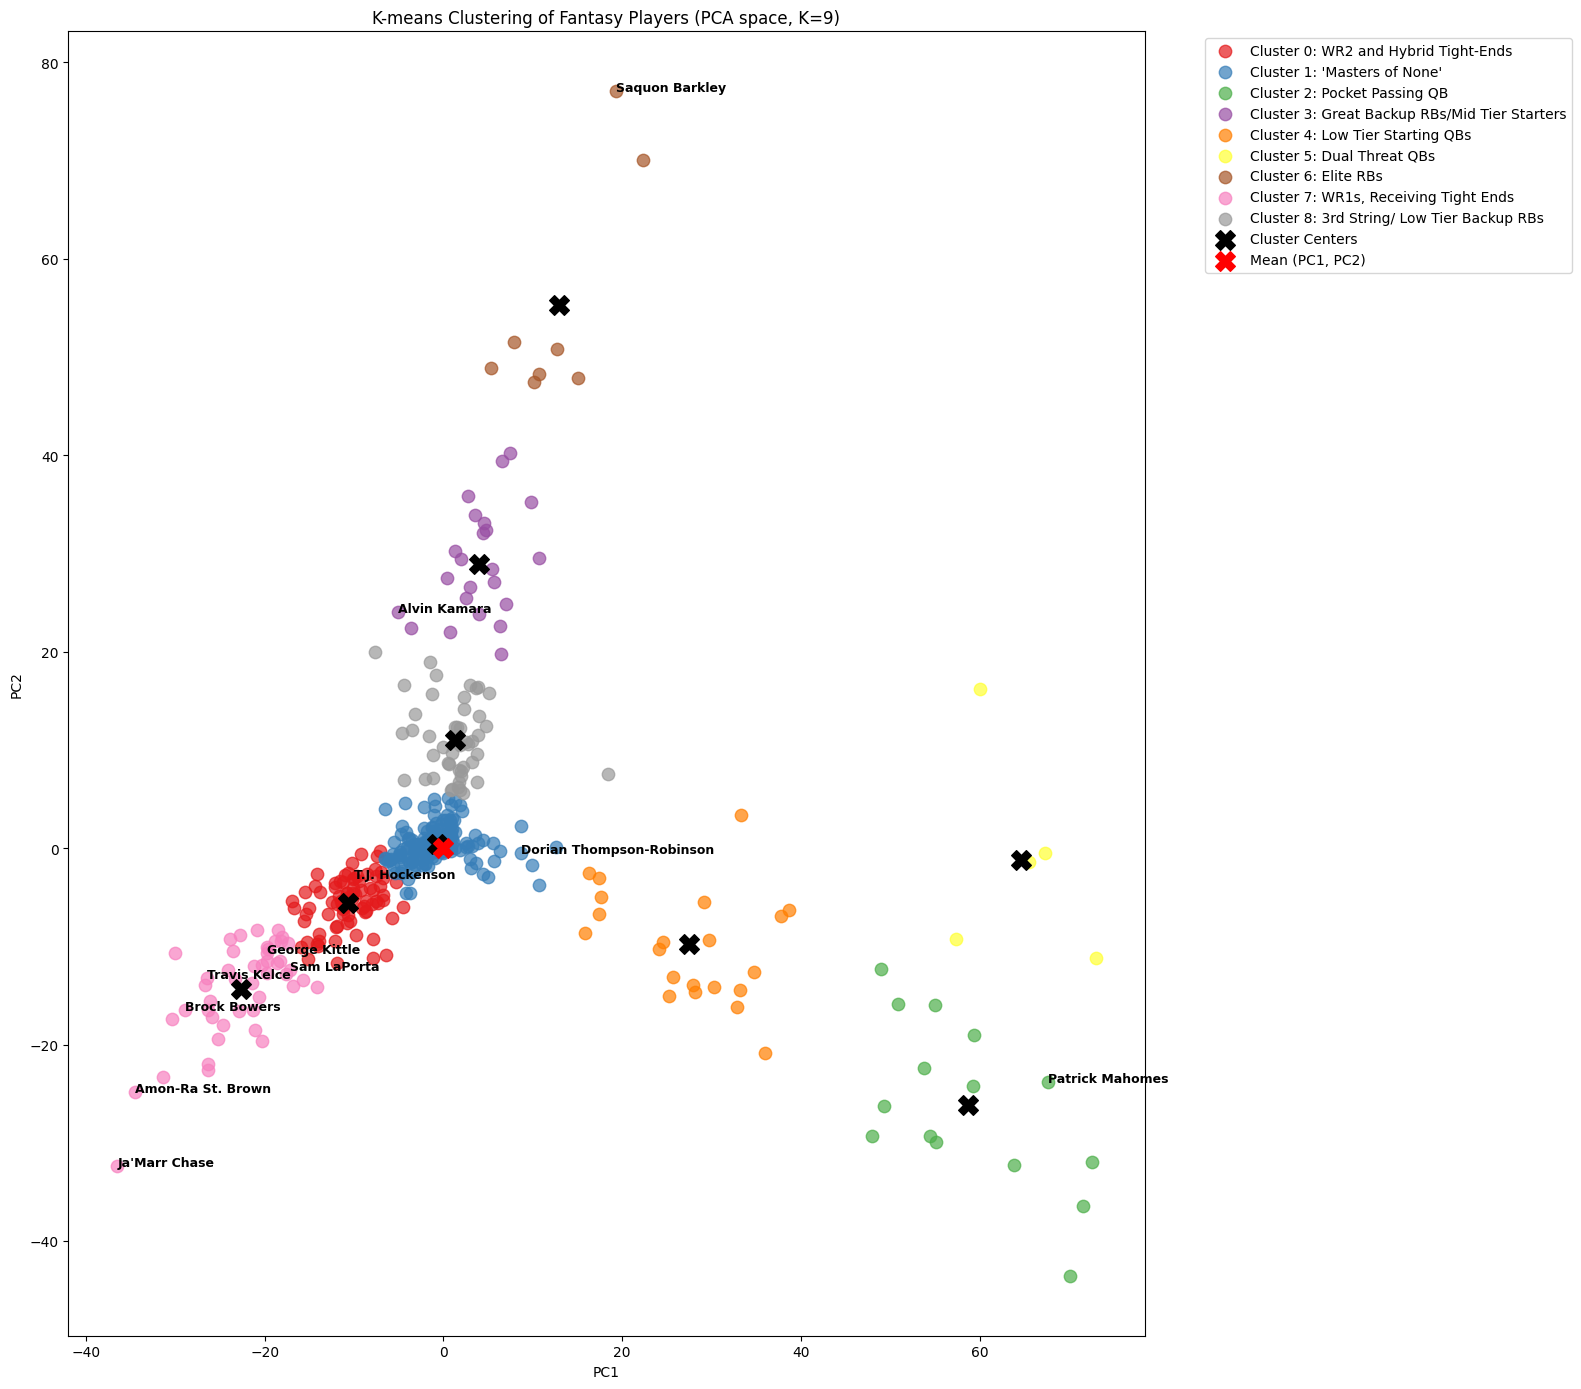

In [85]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Extract PC1 and PC2 as features for clustering
X = player_stats_pca[["PC1", "PC2"]]

# Run K-means with K=9 (not 3, since your mapping has 9 clusters)
kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
player_stats_pca["cluster"] = kmeans.fit_predict(X)

# Define your cluster-color-position mapping
cluster_info = {
    0: ("WR2 and Hybrid Tight-Ends", "#e41a1c"),
    1: ("'Masters of None'", "#377eb8"),
    2: ("Pocket Passing QB", "#4daf4a"),
    3: ("Great Backup RBs/Mid Tier Starters", "#984ea3"),
    4: ("Low Tier Starting QBs", "#ff7f00"),
    5: ("Dual Threat QBs", "#ffff33"),
    6: ("Elite RBs", "#a65628"),
    7: ("WR1s, Receiving Tight Ends", "#f781bf"),
    8: ("3rd String/ Low Tier Backup RBs", "#999999"),
}

# Plot results
plt.figure(figsize=(16,14))
for cluster_id, (pos, color) in cluster_info.items():
    subset = player_stats_pca[player_stats_pca["cluster"] == cluster_id]
    plt.scatter(
        subset["PC1"], subset["PC2"], 
        c=color, s=80, alpha=0.7, label=f"Cluster {cluster_id}: {pos}"
    )

# Plot cluster centers
centers = kmeans.cluster_centers_
plt.scatter(
    centers[:,0], centers[:,1], 
    c="black", s=200, marker="X", label="Cluster Centers"
)

# Annotate standout players
for i, row in player_stats_pca.iterrows():
    if row["player_name"] in ["Patrick Mahomes", "Saquon Barkley", "Ja'Marr Chase", "Amon-Ra St. Brown", "Brock Bowers", "George Kittle", "Travis Kelce", "Alvin Kamara", "Sam LaPorta", "T.J. Hockenson", "Dorian Thompson-Robinson"]:  
        plt.text(row["PC1"], row["PC2"], row["player_name"], fontsize=9, weight="bold")


plt.scatter(pc_means["PC1"], pc_means["PC2"], 
            c="red", s=200, marker="X", label="Mean (PC1, PC2)")
            
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means Clustering of Fantasy Players (PCA space, K=9)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")  # legend outside plot
plt.tight_layout()
plt.show()




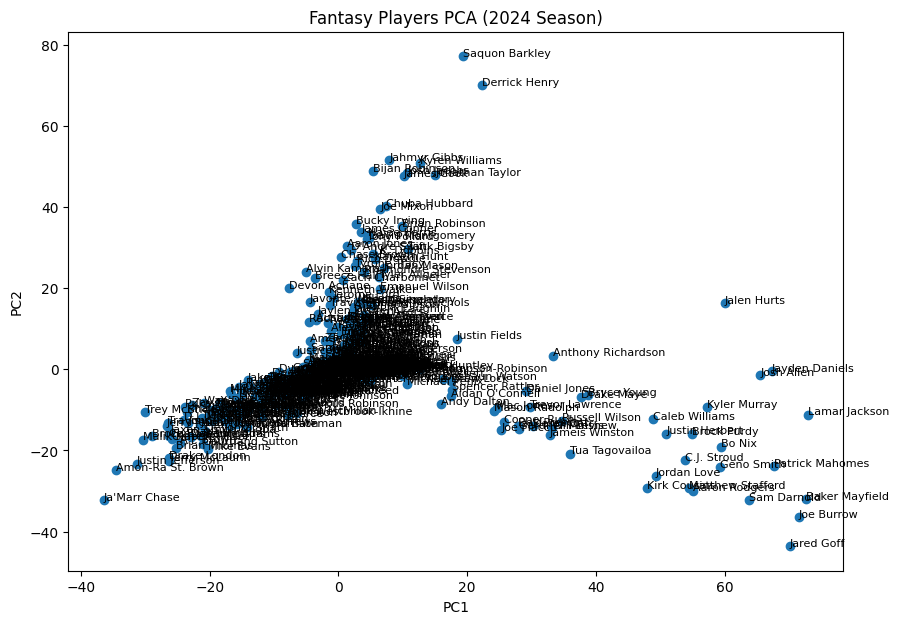

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))
plt.scatter(player_stats_pca["PC1"], player_stats_pca["PC2"])
for i, player in enumerate(player_stats_pca["player_name"]):
    plt.text(player_stats_pca["PC1"][i], player_stats_pca["PC2"][i], player, fontsize=8)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Fantasy Players PCA (2024 Season)")
plt.show()


In [83]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Crosstab: clusters vs actual positions
contingency = pd.crosstab(player_stats_pca["cluster"], player_stats_pca["position"])

# Normalize per cluster to get proportions
contingency_norm = contingency.div(contingency.sum(axis=1), axis=0)

# Identify the majority position in each cluster
cluster_majority = contingency.idxmax(axis=1).to_dict()

# Add labels showing what each cluster "mostly" represents
contingency_labeled = contingency.copy()
contingency_labeled.index = [
    f"Cluster {c} (majority: {cluster_majority[c]})" for c in contingency.index
]

contingency_norm_labeled = contingency_norm.copy()
contingency_norm_labeled.index = [
    f"Cluster {c} (majority: {cluster_majority[c]})" for c in contingency_norm.index
]

print("\nCluster vs Position Counts:\n", contingency_labeled)
print("\nCluster vs Position Proportions:\n", contingency_norm_labeled.round(2))



Cluster vs Position Counts:
 position                  QB  RB  TE  WR
Cluster 0 (majority: WR)   0   0  28  52
Cluster 1 (majority: WR)  32  31  67  88
Cluster 2 (majority: QB)  15   0   0   0
Cluster 3 (majority: RB)   0  23   0   0
Cluster 4 (majority: QB)  21   0   0   0
Cluster 5 (majority: QB)   5   0   0   0
Cluster 6 (majority: RB)   0   8   0   0
Cluster 7 (majority: WR)   0   0   8  38
Cluster 8 (majority: RB)   1  45   1   0

Cluster vs Position Proportions:
 position                    QB    RB    TE    WR
Cluster 0 (majority: WR)  0.00  0.00  0.35  0.65
Cluster 1 (majority: WR)  0.15  0.14  0.31  0.40
Cluster 2 (majority: QB)  1.00  0.00  0.00  0.00
Cluster 3 (majority: RB)  0.00  1.00  0.00  0.00
Cluster 4 (majority: QB)  1.00  0.00  0.00  0.00
Cluster 5 (majority: QB)  1.00  0.00  0.00  0.00
Cluster 6 (majority: RB)  0.00  1.00  0.00  0.00
Cluster 7 (majority: WR)  0.00  0.00  0.17  0.83
Cluster 8 (majority: RB)  0.02  0.96  0.02  0.00


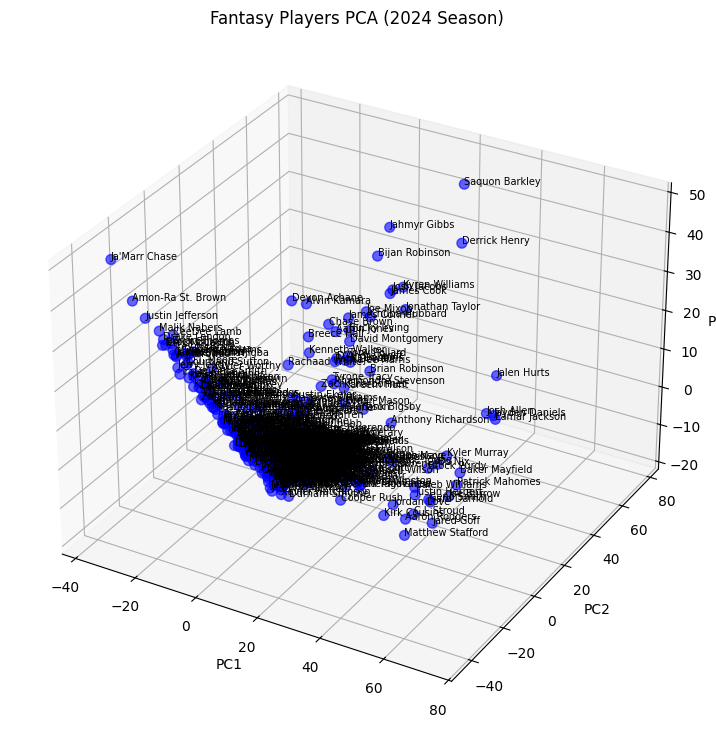

In [84]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter plot
ax.scatter(
    player_stats_pca["PC1"], 
    player_stats_pca["PC2"], 
    player_stats_pca["PC3"],
    c='blue', alpha=0.6, s=50
)

# Annotate player names
for i, player in enumerate(player_stats_pca["player_name"]):
    ax.text(
        player_stats_pca["PC1"][i], 
        player_stats_pca["PC2"][i], 
        player_stats_pca["PC3"][i], 
        player, fontsize=7
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Fantasy Players PCA (2024 Season)")

plt.show()